In [ ]:
import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt

sys.path.append('..')
from src.probability import Distribution
from src.spectral_transforms import psi_real_to_circle, psi_inv_circle_to_real, B_real, B_circle
from src.numerical import trap_quad, fourier_quad
from src.plotting import plot_real_distribution, plot_circle_distribution, plot_circle_distribution_3D

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

ModuleNotFoundError: No module named 'aaa_algorithms'

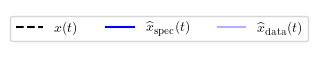

In [55]:
fig, ax = plt.subplots(figsize=(2, 0.5))

# Create empty lines with labels
ax.plot([], [], color="k", linestyle="--")
ax.plot([], [], color="blue")
ax.plot([], [], color="blue", alpha=0.3)
ax.axis('off')

# Create the legend
plt.legend(["$x(t)$", "$\widehat{x}_{\mathrm{spec}}(t)$", "$\widehat{x}_{\mathrm{data}}(t)$"], bbox_to_anchor=[0.5, 0.5], loc='center', fontsize=10, ncol=4)

plt.savefig('figures/traj_legend.pdf', bbox_inches='tight', pad_inches=0.1)

left root found
Solving numerically with trapezoid method


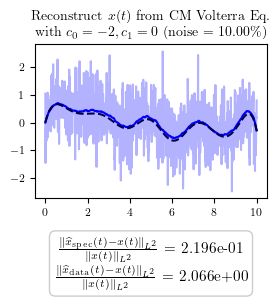

In [48]:
# Define noisy input trajectory x(t)
T = 10
t = np.linspace(0, T, 1000)
dt = t[1] - t[0]

n_interp = 10
np.random.seed(1)
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
x = cs(t)

# Define Volterra equation kernel and coefficients
K = np.exp(-t) + np.exp(-2*t)
c0 = -2
c1 = 0

# Compute output trajectory y(t) and corrupt it with noise
xdot = np.gradient(x, dt)
y = c1*xdot - c0*x - conv_trap(K, x, t)

noise_level = 10
y_noisy = y + noise_level/100 * np.linalg.norm(y) * np.random.randn(len(t))
ydot_noisy = np.gradient(y_noisy, dt)

# Define its analytical spectral distribution lambda
density = None
atoms = np.array([1, 2])
atom_wts = np.array([1, 1])
quad_pts, quad_wts = trap_quad(0, 10, int(1e4))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

# Use the spectral inversion map B to compute the inverse spectra mu and mu_hat from lambda and lambda_hat
mu, zeta0, zeta1 = B_real(lmbda, c0, c1)

# Compute the analytical inverse kernel J corresponding to K, and use it to reconstruct x
J_spectral = exp_kernel(mu, t)
x_spectral = (-1/math.pi**2) * (zeta1*ydot_noisy - zeta0*y - conv_trap(J_spectral, y_noisy, t))

# Compute the numerical inverse kernel J corresponding to K by solving the resolvent equation, and use it to reconstruct x
J_numerical, _, _ = volterra_cm_numerical_inversion(lmbda, c0, c1, t)
x_numerical_res = (-1/math.pi**2) * (zeta1*ydot_noisy - zeta0*y - conv_trap(J_numerical, y_noisy, t))

# Compute the numerical inversion of the Volterra equation from x to y, to reconstruct x, this should be quite noise sensitive
x_numerical_data = solve_volterra(-K, -c0, y_noisy, t)
#x_numerical_data = solve_volterra_integrodiff(-K, -c0, c1, y_noisy, 0, t)

rel_err_spectral = np.linalg.norm(x_spectral - x) / np.linalg.norm(x)
rel_err_numerical_res = np.linalg.norm(x_numerical_res - x) / np.linalg.norm(x)
rel_err_numerical_data = np.linalg.norm(x_numerical_data - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t, x, linestyle='--', color="k")
ax.plot(t, x_spectral, color="blue", zorder=1)
#ax.plot(t, x_numerical_res, color="cyan", zorder=0)
ax.plot(t, x_numerical_data, color="blue", alpha=0.3, zorder=2)
strc = f"with $c_0={c0}, c_1={c1}$"
ax.set_title("Reconstruct $x(t)$ from CM Volterra Eq.\n" + strc +  f" (noise = {noise_level:.2f}\%)", size=10)

ax.annotate("$\\frac{\|\widehat{x}_{\mathrm{spec}}(t) - x(t)\|_{L^2}}{\|x(t)\|_{L^2}}$" + f" = {rel_err_spectral:.3e}" + "\n" +
            #"$\\frac{\|\widehat{x}_{\mathrm{num}}(t) - x(t)\|_{L^2}}{\|x(t)\|_{L^2}}$" + f" = {rel_err_numerical_res:.3e}" + "\n" +
            "$\\frac{\|\widehat{x}_{\mathrm{data}}(t) - x(t)\|_{L^2}}{\|x(t)\|_{L^2}}$" + f" = {rel_err_numerical_data:.3e}",
            xy=(0.5, -0.25), xycoords='axes fraction',
            size=11, ha='center', va='top',
            bbox=dict(fc='w', edgecolor='k', alpha=0.2, boxstyle='round,pad=0.4'))
plt.savefig(f"figures/cm_data_inversion_noise{noise_level}.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

no roots to left or right


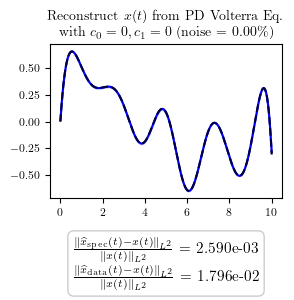

In [69]:
# Define noisy input trajectory x(t)
T = 10
t = np.linspace(0, T, 1000)
dt = t[1] - t[0]

n_interp = 10
np.random.seed(1)
interp_xs = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_xs, k=5)
x = cs(t)

# Define Volterra equation kernel and coefficients
K = np.cos(t) + np.cos(2*t)
c0 = 0
c1 = 0

# Compute output trajectory y(t) and corrupt it with noise
xdot = np.gradient(x, dt)
y = c1*xdot - 1j*c0*x + conv_trap(K, x, t)

noise_level = 0.0
y_noisy = y + noise_level/100 * np.linalg.norm(y) * np.random.randn(len(t))
ydot_noisy = np.gradient(y, dt) #np.gradient(y_noisy, dt)

# Define its analytical spectral distribution lambda
density = None
atoms = np.array([-2, -1, 1, 2])
atom_wts = np.array([1, 1, 1, 1])/2
quad_pts, quad_wts = trap_quad(-10, 10, int(1e4))
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts)

# Use the spectral inversion map B to compute the inverse spectra mu and mu_hat from lambda and lambda_hat
mu, zeta0, zeta1 = B_real(lmbda, c0, c1)

# Compute the analytical inverse kernel J corresponding to K, and use it to reconstruct x
J_spectral = complex_exp_kernel(mu, t)
x_spectral = (1/math.pi**2) * (zeta1*ydot_noisy - 1j*zeta0*y + conv_trap(J_spectral, y_noisy, t))

# Compute the numerical inverse kernel J corresponding to K by solving the resolvent equation, and use it to reconstruct x
J_numerical, _, _ = volterra_pd_numerical_inversion(lmbda, c0, c1, t)
x_numerical_res = (1/math.pi**2) * (zeta1*ydot_noisy - 1j*zeta0*y + conv_trap(J_numerical, y_noisy, t))

# Compute the numerical inversion of the Volterra equation from x to y, to reconstruct x, this should be quite noise sensitive
x_numerical_data = solve_volterra(K, -1j*c0, y_noisy, t)
#x_numerical_data = solve_volterra_integrodiff(K, -1j*c0, c1, y_noisy, 0, t)

rel_err_spectral = np.linalg.norm(x_spectral - x) / np.linalg.norm(x)
rel_err_numerical_res = np.linalg.norm(x_numerical_res - x) / np.linalg.norm(x)
rel_err_numerical_data = np.linalg.norm(x_numerical_data - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(t, x, linestyle='--', color="k")
ax.plot(t, x_spectral, color="blue", zorder=1)
#ax.plot(t, x_numerical_res, color="cyan", zorder=0)
ax.plot(t, x_numerical_data, color="blue", alpha=0.3, zorder=2)
strc = f"with $c_0={c0}, c_1={c1}$"
ax.set_title("Reconstruct $x(t)$ from PD Volterra Eq.\n" + strc +  f" (noise = {noise_level:.2f}\%)", size=10)

ax.annotate("$\\frac{\|\widehat{x}_{\mathrm{spec}}(t) - x(t)\|_{L^2}}{\|x(t)\|_{L^2}}$" + f" = {rel_err_spectral:.3e}" + "\n" +
            #"$\\frac{\|\widehat{x}_{\mathrm{num}}(t) - x(t)\|_{L^2}}{\|x(t)\|_{L^2}}$" + f" = {rel_err_numerical_res:.3e}" + "\n" +
            "$\\frac{\|\widehat{x}_{\mathrm{data}}(t) - x(t)\|_{L^2}}{\|x(t)\|_{L^2}}$" + f" = {rel_err_numerical_data:.3e}",
            xy=(0.5, -0.25), xycoords='axes fraction',
            size=11, ha='center', va='top',
            bbox=dict(fc='w', edgecolor='k', alpha=0.2, boxstyle='round,pad=0.4'))
plt.savefig(f"figures/pd_data_inversion_noise{noise_level}.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()